In [1]:
import torch
from architectures import SolitonGenerator, SolitonDiscriminator
import neptune.new as neptune

In [5]:
args = {
    "n_samples": 1920,
    "n_epochs": 500,
    "device": "cpu",
    "batch_size": 32,
    "Z_dim": 10,
    "J_dim": 10,
    "hidden_dim": 64, # 256
    "gen_rnn_hidden_dim": 64,
    "gen_rnn_num_layers": 2,
    #"dis_rnn_hidden_dim": 100,
    #"dis_rnn_num_layers": 2,
    "num_hidden_layers": 3,
    "feature_dim": 120,
    "max_seq_len": 30,
    "rnn_type": "GRU",
    "use_bn": False,
    "P": 50,
    "spatial_len": 120,
    "dx": 120,
    "dt": 30,
    "t_steps": 30,
    "eta": 6.0,
    "gamma": 1.0,
}

In [6]:
from trainer import create_dataset
dataset = create_dataset("twosolitons", args["n_samples"], args, args["device"] )
dataset[:].size()

dataset: twosolitons
Loading dataset: Two Solitons
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
Concatenated data with shape (3000, 30, 120) and size: 43.2 MB


torch.Size([1920, 30, 120])

In [7]:
SolitonGenerator(args)

SolitonGenerator(
  (gen_rnn): GRU(10, 64, batch_first=True)
  (gen_rnn2): GRU(64, 128, batch_first=True)
  (gen_FC): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=120, bias=True)
    (5): Sigmoid()
  )
)

encoder = SolitonDiscriminator(args)
encoder.to(args["device"])
decoder = SolitonGenerator(args)
decoder.to(args["device"])

z = encoder(dataset[:args["batch_size"]])
x_hat = decoder(z)
x_hat.size()


In [8]:
class Encoder(torch.nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()
        self.args = args
        self.rnn = torch.nn.GRU(
            input_size=args["dx"],
            hidden_size=args["gen_rnn_hidden_dim"],
            num_layers=2,
            batch_first=True,
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(args["gen_rnn_hidden_dim"], 256),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(256, args["Z_dim"]),
        )

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

encoder_test = Encoder(args)
encoder_test(dataset[:1]).size()

torch.Size([1, 30, 10])

In [9]:
from tqdm import trange
from metrics import energy_conservation, mass_conservation, momentum_conservation

neptune_logger =  neptune.init_run(
        project="kohmann/autoencoder",
        name="autoencoder_test",
        tags=["tuning"],
        description="",
        capture_hardware_metrics=True,
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
    )

def eval(x_hat, args, neptune_logger, title="train"):
    dx = args["P"]/args["spatial_len"] # P / M
    H_error = energy_conservation(x_hat, dx=dx, eta=args["eta"], gamma=args["gamma"]).mean().item()
    H_mass_error     = mass_conservation(x_hat, dx=dx).mean().item()
    H_momentum_error = momentum_conservation(x_hat, dx=dx).mean().item()

    neptune_logger["H_mean_error_" + title].log(H_error)
    neptune_logger["H_mass_error_"  + title].log(H_mass_error)
    neptune_logger["H_momentum_error_"  + title].log(H_momentum_error)

def train(args, neptune_logger=None):
    device = args["device"]

    neptune_logger["parameters"] = args

    encoder = Encoder(args)
    decoder = SolitonGenerator(args)

    encoder.to(device)
    decoder.to(device)


    train_data = torch.utils.data.DataLoader(
            dataset=dataset[:int(args["n_samples"] * 0.8)],
            batch_size=args["batch_size"],
            shuffle=False
        )

    optimizer = torch.optim.Adam(
        list(encoder.parameters()) + list(decoder.parameters()), lr=0.001
    )
    loss = torch.nn.MSELoss()
    train_data_test = dataset[:int(args["n_samples"] * 0.8)]
    test_data_test = dataset[int(args["n_samples"] * 0.8):]

    logger = trange(args["n_epochs"], desc=f"Epoch: 0, MSE: 0")
    for epoch in logger:
        batch_losses = 0
        for x in train_data:
            optimizer.zero_grad()
            x = x.to(device)
            z = encoder(x)
            x_hat = decoder(z)
            loss_value = loss(x_hat, x)
            loss_value.backward()
            optimizer.step()
            batch_losses += loss_value.detach().item()
        logger.set_description(f"Epoch: {epoch}, MSE: {loss_value.item():.4f}")
        mean_loss = batch_losses / (args["n_samples"] / args["batch_size"])

        with torch.no_grad():
            z_train = encoder(train_data_test)
            fake_train = decoder(z_train).detach().cpu()

            z_test = encoder(test_data_test)
            fake_test = decoder(z_test).detach().cpu()
            mse_test = loss(fake_test, test_data_test).item()
        eval(fake_train, args, neptune_logger, title="train")
        eval(fake_test,  args, neptune_logger, title="test")

        neptune_logger["MSE_train"].log(mean_loss)
        neptune_logger["MSE_test"].log(mse_test)
    return encoder, decoder
encoder, decoder = train(args, neptune_logger=neptune_logger)
neptune_logger.stop()

https://app.neptune.ai/kohmann/autoencoder/e/AUT-27


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/help/nvml_error/


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Epoch: 499, MSE: 0.0001: 100%|██████████| 500/500 [10:46<00:00,  1.29s/it]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 34 operations to synchronize with Neptune. Do not kill this process.


All 34 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/autoencoder/e/AUT-27


In [ ]:
# plot some results using the logger

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


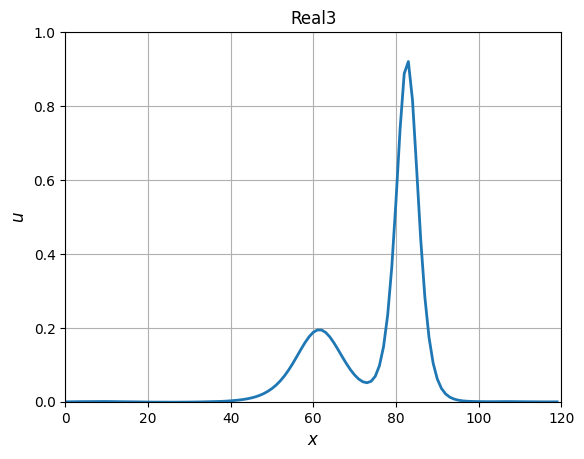

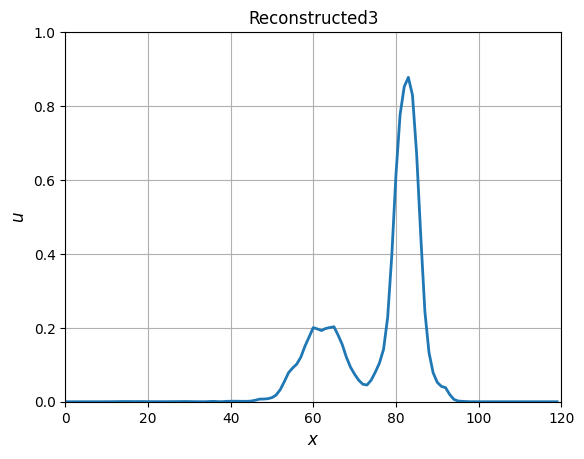

In [18]:
from matplotlib import animation, rc
import matplotlib.pyplot as plt
import numpy as np
def animate_single(data, title):
    rc('animation', html='jshtml')
    fig, ax = plt.subplots()
    line, = ax.plot([], [], lw=2)
    ax.set_xlim((0, data.shape[1]))
    ax.set_ylim((0, 1))
    ax.set_xlabel('$x$', fontsize=12)
    ax.set_ylabel('$u$', fontsize=12)
    ax.grid()
    plt.title(title)
    #x = np.arange(data.shape[1])
    x = torch.arange(data.shape[1])
    def init():
        line.set_data([], [])
        return (line,)
    def animate(i):
        line.set_data(x, data[i,:])
        return (line,)
    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                  frames=data.shape[0], interval=20, blit=True)
    ani.save('plots/' + title + '.gif', fps=15)

n = 8
ani = animate_single(dataset[n].detach().numpy(), "Real3")
z = encoder(dataset[n])
x_hat = decoder(z)
ani = animate_single(x_hat.detach().numpy(), "Reconstructed3")

In [58]:
# Load best model
#torch.save(encoder.state_dict(), "models/encoder-AUT25.pt")
#torch.save(decoder.state_dict(), "models/decoder-AUT25.pt")

encoder = Encoder(args)
decoder = SolitonGenerator(args)
encoder.load_state_dict(torch.load("models/encoder-AUT25.pt"))
decoder.load_state_dict(torch.load("models/decoder-AUT25.pt"))

<All keys matched successfully>